# Transfer learning for Mixed Eye Disease Fundus

## General Libraries

In [44]:
import os
import csv
import PIL
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tensorflow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, model_from_json, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# Sklearn
from sklearn.model_selection import train_test_split

In [45]:
# Check Tensorflow version

print('Current Tensorflow version:', tf.__version__)

Current Tensorflow version: 2.10.1


In [46]:
# Check GPUs availability

print('Num GPUs available:', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs available: 1


In [47]:
# Check Cuda availability

print('Built with CUDA:', tf.test.is_built_with_cuda())
print('Built with GPU support:', tf.test.is_built_with_gpu_support())
print('List physical devices:\n', tf.config.list_physical_devices())
print('List logical devices:\n', tf.config.list_logical_devices())

Built with CUDA: True
Built with GPU support: True
List physical devices:
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
List logical devices:
 [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]


## Data exploration

### Set the base directory

In [48]:
# Set the base directory

main_project_dir = 'D:/2110191048'
main_dataset_dir = os.path.join(main_project_dir, 'Dataset')
dataset_dir = os.path.join(main_dataset_dir, 'Dataset (Splitted)')

def is_directory_exists(path):
    if os.path.exists(path):
        print(f'"{path}" directory is exist')
    else:
        print(f'"{path}" directory is not exist')

is_directory_exists(main_project_dir)
is_directory_exists(main_dataset_dir)
is_directory_exists(dataset_dir)

print('\nProject directory:', main_project_dir)
print('Main dataset directory:', main_dataset_dir)
print('Used dataset directory:', dataset_dir)

"D:/2110191048" directory is exist
"D:/2110191048\Dataset" directory is exist
"D:/2110191048\Dataset\Dataset (Splitted)" directory is exist

Project directory: D:/2110191048
Main dataset directory: D:/2110191048\Dataset
Used dataset directory: D:/2110191048\Dataset\Dataset (Splitted)


In [49]:
os.getcwd()

'd:\\2110191048\\eye-disease-classification-app\\deep-learning-model'

### Explore original dataset

In [50]:
# Create function to generate CSV file based on dataset directory

def create_csv_file_from_dataset(filename, path, headers, dataset_source, dataset_type=''):
    supported_extensions = ['.png', '.jpg', '.jpeg']
    file_path = os.path.join(path, filename)

    try:
        with open(file_path, 'w', newline='') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(headers)
        
        for root, dirs, files in os.walk(dataset_source + '/' + dataset_type):
            for file in files:
                if any(file.lower().endswith(ext) for ext in supported_extensions):
                    image_path = os.path.join(root, file)
                    label = os.path.basename(root)
                    with open(file_path, 'a', newline='') as csv_file:
                        writer = csv.writer(csv_file)
                        writer.writerow([file, label])
        
        print('Generating CSV file is completed.')
    except (FileNotFoundError, PermissionError) as e:
        print(f'An error occured: {e}')
    finally:
        csv_file.close()
    
    print(f'CSV file successfully created in "{file_path}"')

In [51]:
# Create the glaucoma normal splitted dataset CSV

csv_file_name = 'original_mixed_dataset.csv'
csv_path = main_dataset_dir
dataset_source = os.path.join(csv_path, 'Dataset')
headers = ['Image', 'Label']

create_csv_file_from_dataset(csv_file_name, csv_path, headers, dataset_source)

Generating CSV file is completed.
CSV file successfully created in "D:/2110191048\Dataset\original_mixed_dataset.csv"


In [52]:
# Load and preview the CSV dataset file

mixed_df = pd.read_csv(os.path.join(main_dataset_dir, csv_file_name))
mixed_df

,Image,Label
0,mixed - 10 - cataract (1).jpg,Cataract
1,mixed - 10 - cataract (10).jpg,Cataract
2,mixed - 10 - cataract (100).jpg,Cataract
3,mixed - 10 - cataract (1000).jpg,Cataract
4,mixed - 10 - cataract (1001).jpg,Cataract
...,...,...
4307,mixed - 10 - normal (995).jpg,Normal
4308,mixed - 10 - normal (996).jpg,Normal
4309,mixed - 10 - normal (997).jpg,Normal
4310,mixed - 10 - normal (998).jpg,Normal


In [53]:
# Show dataset dataframe properties

def show_dataset_properties(dataset_df):
    print('mixed_df shape  :', mixed_df.shape)
    print('mixed_df axes   :', mixed_df.axes)
    print('mixed_df labels :', mixed_df['Label'].unique())

    print('\nNumber of images in each class:\n', mixed_df.groupby('Label')['Image'].nunique())

    label_count = mixed_df.groupby('Label')['Image'].nunique()
    label_count = label_count.to_numpy()
    print('\nCataract images\t\t:', label_count[0])
    print('DR images\t\t:', label_count[1])
    print('Glaucoma images\t\t:', label_count[2])
    print('Normal Eye images\t:', label_count[3])

In [54]:
show_dataset_properties(mixed_df)

mixed_df shape  : (4312, 2)
mixed_df axes   : [RangeIndex(start=0, stop=4312, step=1), Index(['Image', 'Label'], dtype='object')]
mixed_df labels : ['Cataract' 'DR' 'Glaucoma' 'Normal']

Number of images in each class:
 Label
Cataract    1038
DR          1098
Glaucoma    1105
Normal      1071
Name: Image, dtype: int64

Cataract images		: 1038
DR images		: 1098
Glaucoma images		: 1105
Normal Eye images	: 1071


In [55]:
# Create function to plot dataset count in each class

def plot_dataset(dataset_df, title, figsize=(7, 6)):
    category_counts = dataset_df['Label'].value_counts()

    plt.figure(figsize=figsize)
    ax = category_counts.plot(kind='bar')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title(title)

    for i, count in enumerate(category_counts):
        plt.text(i, count, str(count), ha='center', va='bottom')

    plt.setp(ax.get_xticklabels(), rotation=0)
    plt.tight_layout()
    plt.show()

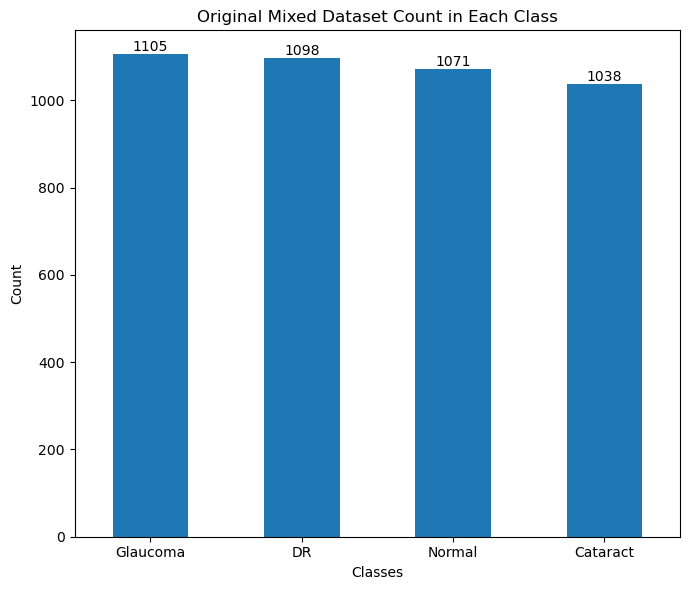

In [56]:
# Plotting the dataset count in each class

plot_title = 'Original Mixed Dataset Count in Each Class'
plot_dataset(mixed_df, plot_title)

In [57]:
# Set the train, val, and test dataset path

train_url = os.path.join(dataset_dir, 'train')
val_url = os.path.join(dataset_dir, 'val')
test_url = os.path.join(dataset_dir, 'test')

# Using pathlib so we can iterate and count images inside the directory
train_dir = pathlib.Path(train_url)
val_dir = pathlib.Path(val_url)
test_dir = pathlib.Path(test_url)

print('Train directory\t:', train_dir)
print('Val directory\t:', val_dir)
print('Test directory\t:', test_dir)

Train directory	: D:\2110191048\Dataset\Dataset (Splitted)\train
Val directory	: D:\2110191048\Dataset\Dataset (Splitted)\val
Test directory	: D:\2110191048\Dataset\Dataset (Splitted)\test


In [58]:
# Image count in each dataset

train_count = len(list(train_dir.glob('*/*')))
val_count = len(list(val_dir.glob('*/*')))
test_count = len(list(test_dir.glob('*/*')))

print('Total training set images:\t', train_count)
print('Total validation set images\t:', val_count)
print('Total test set images\t\t:', test_count)

Total training set images:	 3879
Total validation set images	: 213
Total test set images		: 220


In [59]:
# Create dictionary of datagens and generators from each dataset

data_dicts = {
    'train':[],
    'test':[],
    'val':[]
}

data_labels = {
    'train':[],
    'test':[],
    'val':[]
}

### Plot the class distribution

Train information
---------------
Label names		: ['Cataract', 'DR', 'Glaucoma', 'Normal']
Label counts		: [934, 988, 994, 963]
Total image count	: 3879 

Val information
---------------
Label names		: ['Cataract', 'DR', 'Glaucoma', 'Normal']
Label counts		: [51, 54, 55, 53]
Total image count	: 213 

Test information
---------------
Label names		: ['Cataract', 'DR', 'Glaucoma', 'Normal']
Label counts		: [53, 56, 56, 55]
Total image count	: 220 



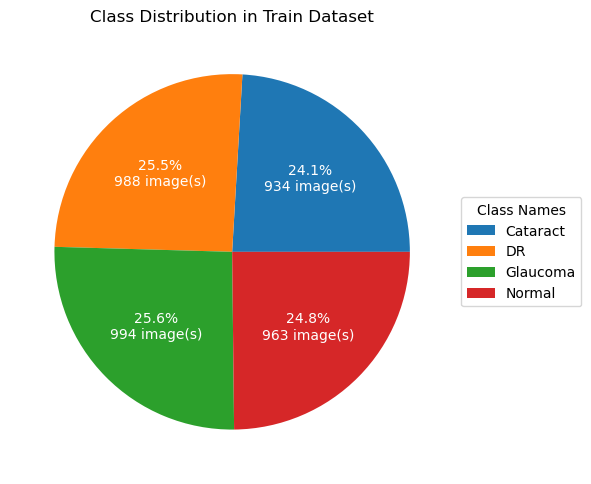

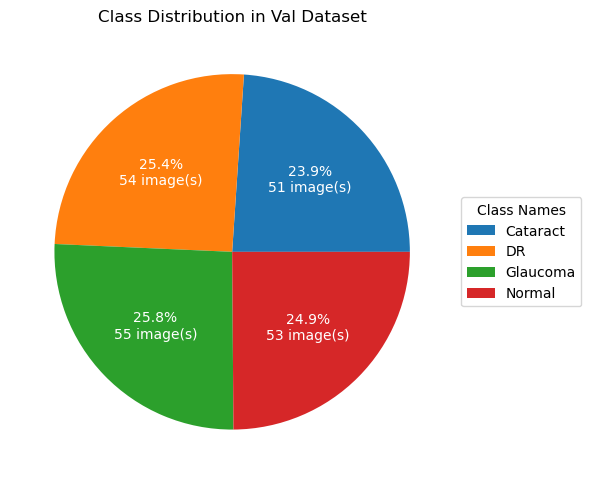

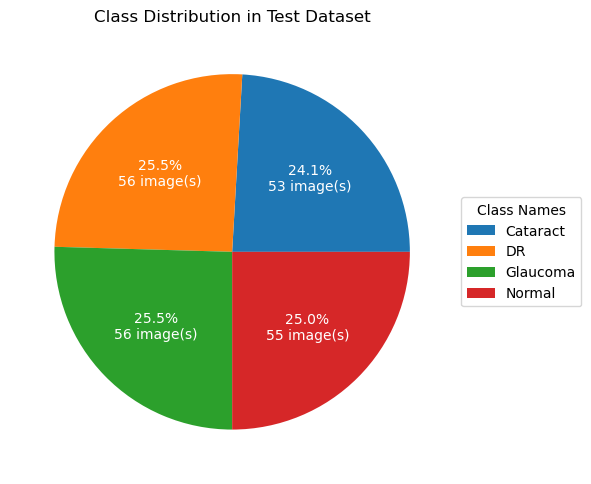

In [60]:
# Set and plot each dataset's classes distribution

for phase in ['train', 'val', 'test']:
    if phase == 'train':
        data_dir = train_dir
    elif phase == 'val':
        data_dir = val_dir
    elif phase == 'test':
        data_dir = test_dir

    class_names = sorted(x for x in os.listdir(data_dir)
                            if os.path.isdir(os.path.join(data_dir, x)))
    num_class = len(class_names) 

    image_files = [[
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ] for i in range(num_class)]

    num_each = [len(image_files[i]) for i in range(num_class)]
    image_files_list = [] 
    image_class = []

    for i in range(num_class):
        image_files_list.extend(image_files[i])
        image_class.extend([i] * num_each[i])

    data_dicts[phase] = image_files_list
    data_labels[phase] = image_class
    num_total = len(image_class)
    image_width, image_height = PIL.Image.open(image_files_list[0]).size
    
    print(f'{phase.capitalize()} information')
    print('-'*15)
    print(f'Label names\t\t: {class_names}')
    print(f'Label counts\t\t: {num_each}')
    print(f'Total image count\t: {num_total}', '\n')

    def func(pct, allvals):
        absolute = int(np.round(pct/100.*np.sum(allvals)))
        return f"{pct:.1f}%\n{absolute:d} image(s)"

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(num_each, 
                                        labels=class_names, 
                                        autopct=lambda pct: func(pct, num_each), 
                                        textprops=dict(color='w'))
    ax.legend(wedges, 
                class_names,
                title='Class Names',
                loc='center left',
                bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_title(f'Class Distribution in {phase.capitalize()} Dataset')
    plt.tight_layout()

In [61]:
def plot_class_distribution_bar_chart(dataset_dir):
    dataset_types = ['train', 'val', 'test']

    for dataset_type in dataset_types:
        classes = []
        counts = []

        # Iterate over the directories in the dataset type directory
        for root, dirs, files in os.walk(os.path.join(dataset_dir, dataset_type)):
            for dir_name in dirs:
                # Get the class name and count the number of images
                class_name = dir_name
                image_count = len(os.listdir(os.path.join(root, dir_name)))
                classes.append(class_name)
                counts.append(image_count)

        # Plot the chart
        plt.figure(figsize=(6, 5))

        if len(classes) <= 10:
            # If there are fewer than or equal to 10 classes, plot a bar chart
            plt.bar(classes, counts)
            plt.xlabel('Class')
            plt.ylabel('Count')
            plt.title('Class Distribution in ' + dataset_type.capitalize() + ' Dataset')

            for i in range(len(classes)):
                plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
        else:
            # If there are more than 10 classes, plot a pie chart
            plt.pie(counts, labels=classes, autopct='%1.1f%%')
            plt.title('Class Distribution in ' + dataset_type.capitalize() + ' Dataset')

        plt.tight_layout()
        plt.show()

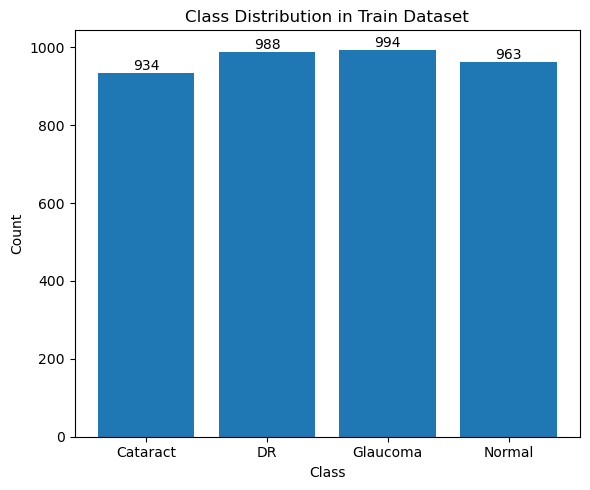

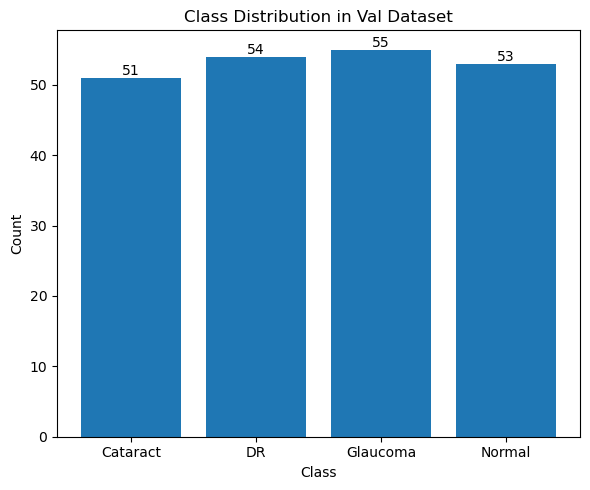

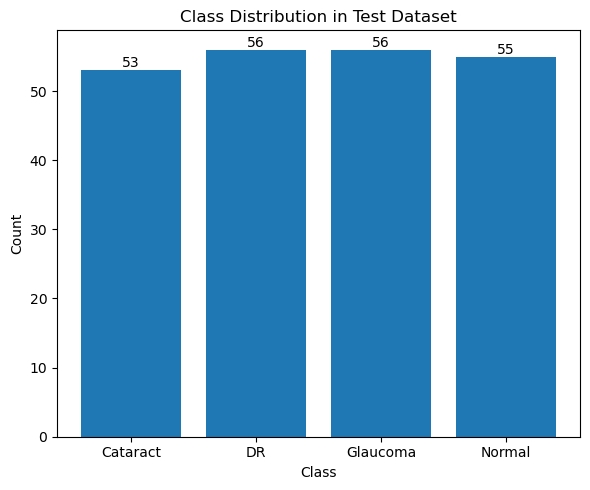

In [62]:
plot_class_distribution_bar_chart(dataset_dir)

In [63]:
def plot_class_distribution_grouped_bar_chart(dataset_dir):
    classes = []
    counts_train = []
    counts_val = []
    counts_test = []

    # Iterate over the directories in the train dataset
    for root, dirs, files in os.walk(os.path.join(dataset_dir, 'train')):
        for dir_name in dirs:
            class_name = dir_name
            image_count = len(os.listdir(os.path.join(root, dir_name)))
            classes.append(class_name)
            counts_train.append(image_count)

    # Iterate over the directories in the val dataset
    for root, dirs, files in os.walk(os.path.join(dataset_dir, 'val')):
        for dir_name in dirs:
            class_name = dir_name
            image_count = len(os.listdir(os.path.join(root, dir_name)))
            counts_val.append(image_count)

    # Iterate over the directories in the test dataset
    for root, dirs, files in os.walk(os.path.join(dataset_dir, 'test')):
        for dir_name in dirs:
            class_name = dir_name
            image_count = len(os.listdir(os.path.join(root, dir_name)))
            counts_test.append(image_count)

    # Create an array to store the x-axis positions
    x_positions = np.arange(len(classes))

    # Set the width of each bar
    bar_width = 0.25

    # Plot the grouped bars
    plt.figure(figsize=(8, 6))
    plt.bar(x_positions - bar_width, counts_train, width=bar_width, label='Train')
    plt.bar(x_positions, counts_val, width=bar_width, label='Val')
    plt.bar(x_positions + bar_width, counts_test, width=bar_width, label='Test')

    # Set the x-axis labels
    plt.xticks(x_positions, classes)

    # Add the numbers of each dataset to the bars
    for i, count in enumerate(counts_train):
        plt.text(i - bar_width, count, str(count), ha='center', va='bottom')
    for i, count in enumerate(counts_val):
        plt.text(i, count, str(count), ha='center', va='bottom')
    for i, count in enumerate(counts_test):
        plt.text(i + bar_width, count, str(count), ha='center', va='bottom')

    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title('Image Counts by Class and Dataset Type')
    plt.legend()

    plt.tight_layout()
    plt.show()


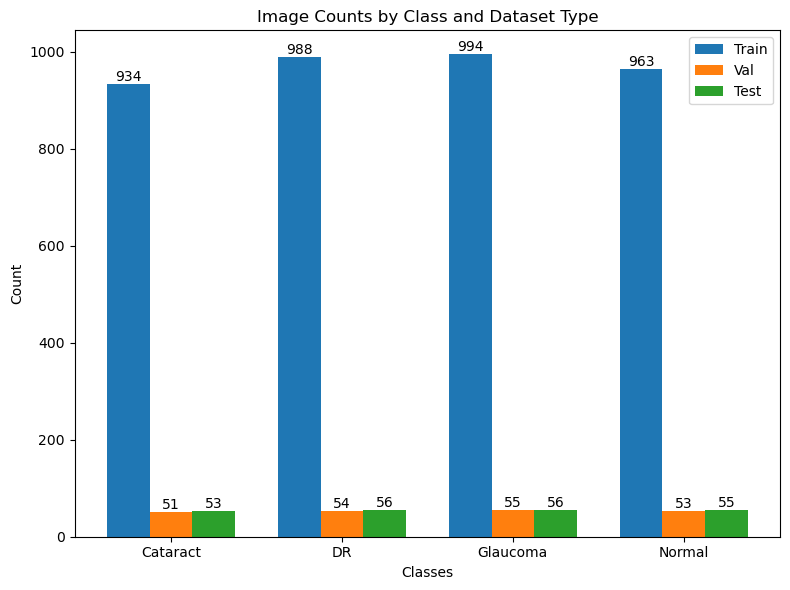

In [64]:
plot_class_distribution_grouped_bar_chart(dataset_dir)

## Data loading & augmentation

### Set some training parameters

In [65]:
# Set some training hyperparameters

BATCH_SIZE = 32

IMG_SIZE_1 = 32
IMG_SIZE_2 = 64
IMG_SIZE_3 = 100
IMG_SIZE_4 = 128
IMG_SIZE_5 = 180
IMG_SIZE_6 = 224
IMG_SIZE_7 = 256
IMG_SIZE = (IMG_SIZE_3, IMG_SIZE_3)

print('BATCH_SIZE:', BATCH_SIZE)
print('IMG_SIZE:', IMG_SIZE, '| IMG_SIZE type:', type(IMG_SIZE))

BATCH_SIZE: 32
IMG_SIZE: (100, 100) | IMG_SIZE type: <class 'tuple'>


In [66]:
# Import the preprocessing input function from the model to be used

from tensorflow.keras.applications.resnet_v2 import preprocess_input

In [67]:
# Create the datagen for each dataset using ImageDataGenerator (this library is deprecated since TF 2.10)

datagen = {
    'train': ImageDataGenerator(
        # rescale=1/255.0,
        vertical_flip=True,
        horizontal_flip=True,
        rotation_range=20,
        fill_mode='constant',
        # shear_range=5.0,
        # zoom_range=[0.5, 1.0],
        # brightness_range=(0.5, 1.5),
        # width_shift_range=(0.0, 0.15),
        # height_shift_range=(0.0, 0.15),
        preprocessing_function=preprocess_input

    ),
    'val': ImageDataGenerator(
        preprocessing_function=preprocess_input
        # rescale=1/255.0,
    ),
    'test': ImageDataGenerator(
        preprocessing_function=preprocess_input
        # rescale=1/255.0,
    ),
}

In [68]:
# Create the image generator for each dataset using ImageDataGenerator (this library is deprecated since TF 2.10)

test_image_source = 'mixed_test_images/Cataract.jpg'
augmentation_dest_path = 'mixed_augmentations_examples'

data_sets = {
    'train': datagen['train'].flow_from_directory(
        train_dir, 
        shuffle=True, 
        seed=42, 
        class_mode='sparse', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE,

        # Uncomment these lines if we want to preview and save some augmented images
        # save_to_dir=augmentation_dest_path,
        # save_prefix='aug',
        # save_format='png'
    ),
    'val': datagen['val'].flow_from_directory(
        val_dir, 
        shuffle=True, 
        class_mode='sparse', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE,
    ),
    'test': datagen['test'].flow_from_directory(
        test_dir, 
        shuffle=False, 
        class_mode='sparse', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE
    )
}

Found 3879 images belonging to 4 classes.
Found 213 images belonging to 4 classes.
Found 220 images belonging to 4 classes.


In [69]:
# Uncomment this cell if we want to preview and save some augmented images

# 
# test_image_source = 'mixed_test_images/Cataract.jpg'
# augmentation_dest_path = 'mixed_augmentations_examples'
# 
# i = 0
# 
# for batch in data_sets['train']:
#     i = i + 1
#     if i >= 30:
#         break

In [70]:
# Let's take a look at the dataset properties after being created with ImageDataGenerator 

for i, (images, labels) in enumerate(data_sets['train']):
    print('Test dataset labels shape:', labels.shape)
    print('Test dataset images shape:', images.shape)
    break

Test dataset labels shape: (32,)
Test dataset images shape: (32, 100, 100, 3)


In [71]:
# Check if the image is rescaled or preprocessed

for k in range(len(images)):
    print(f'Max: {np.max(images[k])} | Min: {np.min(images[k])}')

Max: 0.995232343673706 | Min: -1.0
Max: 0.9592939615249634 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 0.980687141418457 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 0.9922986030578613 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 0.9662185907363892 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 0.9240469932556152 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 0.9726669788360596 | Min: -1.0
Max: 0.9609646797180176 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 0.9990729093551636 | Min: -1.0
Max: 0.9999370574951172 | Min: -1.0
Max: 0.4949307441711426 | Min: -1.0
Max: 0.8926032781600952 | Min: -1.0
Max: 0.16089773178100586 | Min: -1.0
Max: 0.962795615196228 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 1.0 | Min: -1.0
Max: 0.8441044092178345 | Min: -1.0


### Preview the image dataset

In [72]:
def show_images_from_dataset(dataset_type):
    if dataset_type not in ['train', 'val', 'test']:
        raise ValueError("Invalid dataset_type. Choose 'train', 'val', or 'test'.")

    # Get a batch of images and their labels
    images, labels = next(data_sets[dataset_type])

    # Configure the figure for plotting
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.flatten()

    # Plot each image with its corresponding label
    for img, label, ax in zip(images, labels, axes):

        # Use this below code if you must converts image from [-1,1] to [0,255]
        # img_array = image.img_to_array(img)
        # norm_img = cv.normalize(img_array, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
        # ax.imshow(norm_img.astype('uint8'))

        ax.imshow(img.astype('uint8'))
        ax.set_title(f"Class: {class_names[int(label)]}")
        ax.axis('on')
    
    if dataset_type == 'train':
        plt.suptitle('Preprocessed/Augmented Train Images')
    elif dataset_type == 'val':
        plt.suptitle('Preprocessed/Augmented Validation Images')
    elif dataset_type == 'test':
        plt.suptitle('Preprocessed/Augmented Test Images')

    # Show the plot
    plt.tight_layout()
    plt.show()

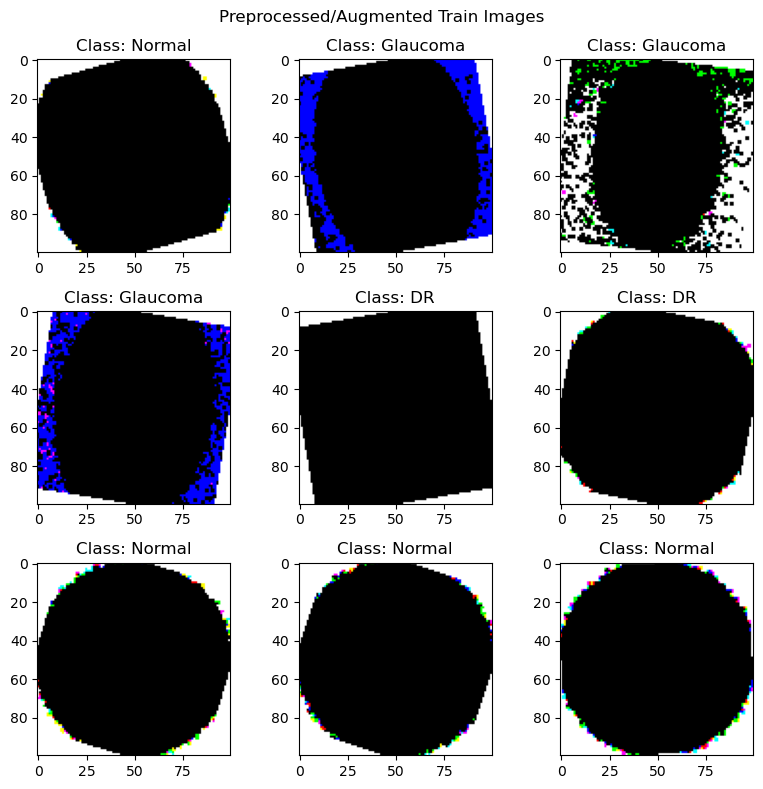

In [73]:
# Check and show images from training data generator

show_images_from_dataset('train')

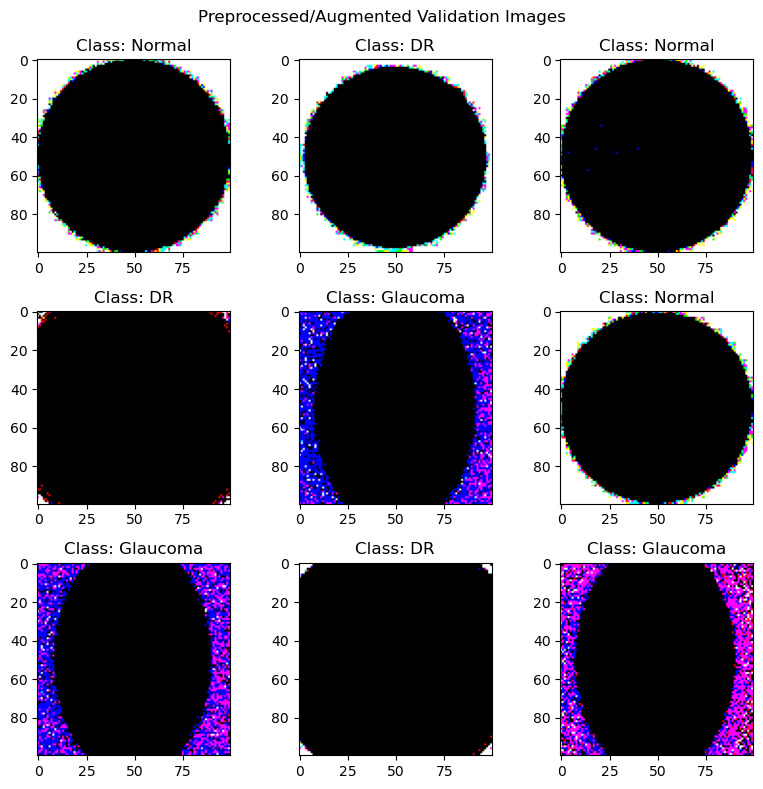

In [74]:
# Check and show images from validation data generator

show_images_from_dataset('val')

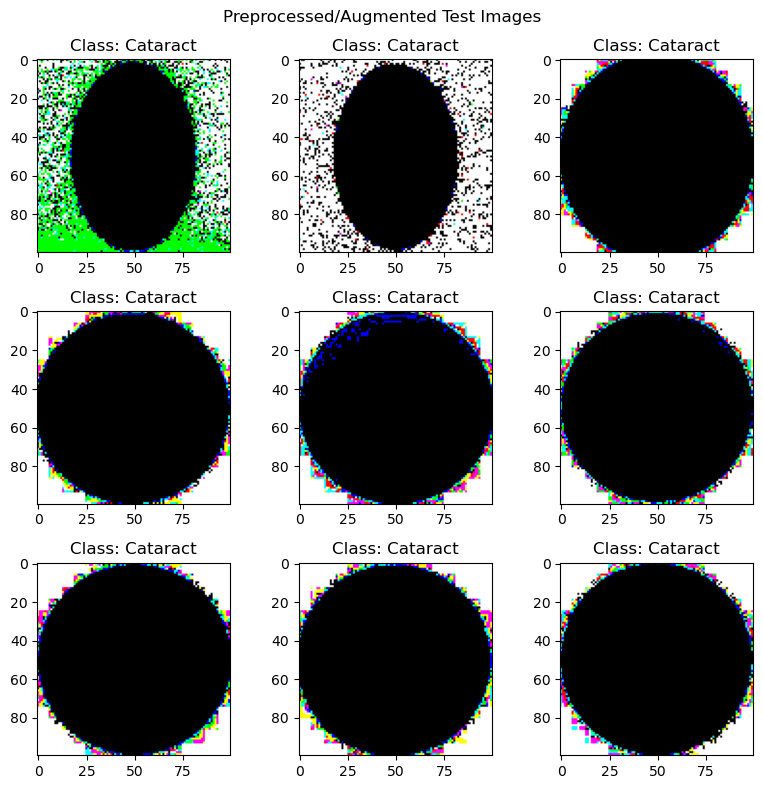

In [75]:
# Check and show images from test data generator

show_images_from_dataset('test')

## Create the base model

In [76]:
# Create the base model from the pre-trained model - ResNet50V2

IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.ResNet50V2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

## Feature extraction

### Freeze the trainable layers

In [77]:
# Freeze the trainable layers

base_model.trainable = False

In [78]:
# Take a look at the base model architecture

base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 52, 52, 64)   0           ['conv1_conv[0][0]']    

### Add additional top layers

In [79]:
# Create the whole model with some additional top layers

model = tf.keras.Sequential()
model.add(base_model)

# These layers could be modified for further experiments
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [80]:
# Take a look at the new whole model architecture now
# Based on layers that we have added in the code above, we can observe from the model summary in 
# "trainable params" section that there are additional layers 

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                      

### Compile the model

In [81]:
BASE_LR = 0.0001

model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LR), # Optimizers could be changed for further experiments
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
)

In [82]:
# Check again whether this model summary is different from before or not

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                      

In [83]:
len(model.trainable_variables)

8

In [84]:
# Try to evaluate the model using validation dataset before training process

loss0, accuracy0 = model.evaluate(data_sets['val'])

print("Initial loss: {:.2f}".format(loss0))
print("Initial accuracy: {:.2f}".format(accuracy0))

7/7 [==============================] - 8s 774ms/step - loss: 2.2459 - accuracy: 0.2582
Initial loss: 2.25
Initial accuracy: 0.26


### Define some model callbacks

In [85]:
# Define some callbacks for the model

trained_model_path = 'trained_model'

# Model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(trained_model_path, 'resnet50v2_mixed_best_model.h5'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, # This could be changed in the future for further experiments
    verbose=1,
    restore_best_weights=True,
    min_delta=0.1 # This could be changed in the future for further experiments
)

# Reduce LR on Plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.8,
    patience=3, 
    min_lr=1e-5, 
    verbose=1
)

# Tensorboard
tensorboard = tf.keras.callbacks.TensorBoard(os.path.join(trained_model_path, 'tb_logs/run_logs'))

### Train the whole model

In [86]:
INIT_EPOCH = 30 # This could be changed for further experiments

history = model.fit(
    data_sets['train'],
    epochs=INIT_EPOCH,
    validation_data=data_sets['val'],
    callbacks=[model_checkpoint, tensorboard]
)

Epoch 1/30
122/122 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.7249
Epoch 1: val_loss improved from inf to 0.46032, saving model to trained_model\resnet50v2_mixed_best_model.h5
122/122 [==============================] - 110s 855ms/step - loss: 0.7404 - accuracy: 0.7249 - val_loss: 0.4603 - val_accuracy: 0.8451
Epoch 2/30
122/122 [==============================] - ETA: 0s - loss: 0.4104 - accuracy: 0.8505
Epoch 2: val_loss improved from 0.46032 to 0.35217, saving model to trained_model\resnet50v2_mixed_best_model.h5
122/122 [==============================] - 101s 829ms/step - loss: 0.4104 - accuracy: 0.8505 - val_loss: 0.3522 - val_accuracy: 0.8873
Epoch 3/30
122/122 [==============================] - ETA: 0s - loss: 0.3460 - accuracy: 0.8750
Epoch 3: val_loss did not improve from 0.35217
122/122 [==============================] - 100s 818ms/step - loss: 0.3460 - accuracy: 0.8750 - val_loss: 0.3539 - val_accuracy: 0.8779
Epoch 4/30
122/122 [==================

### Learning curves

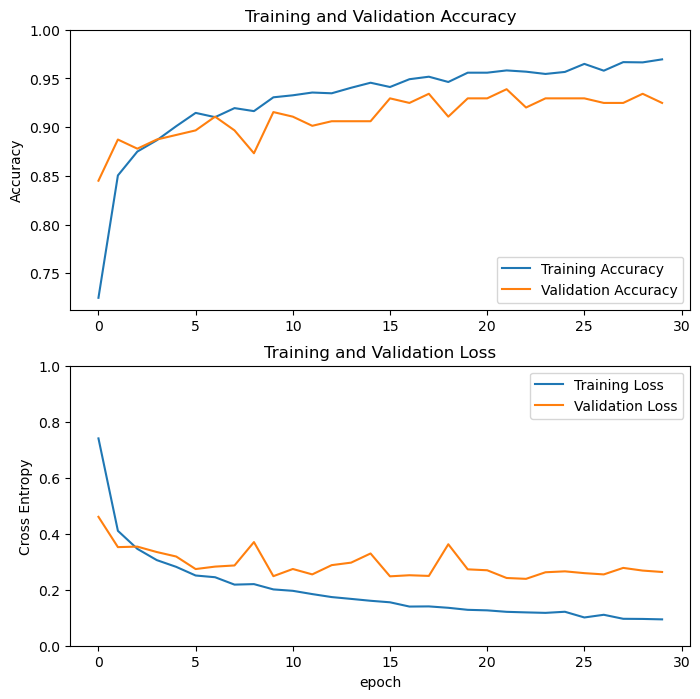

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

**Explanation of fine tuning**

In the feature extraction experiment, we were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier we added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after we have trained the top-level classifier with the pre-trained model set to non-trainable. If we add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and our pre-trained model will forget what it has learned.

Also, we should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As we go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model

In [88]:
# Un-freeze the base model

base_model.trainable = True

In [89]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model:", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100 # This could be changed for further experiments

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model: 190


### Compile the model

In [90]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=BASE_LR/10),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [91]:
# Take a final look at the model summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                      

In [92]:
len(model.trainable_variables)

90

### Continue training the model

In [93]:
FINE_TUNE_EPOCHS = 10 # This could be changed for further experiments
TOTAL_EPOCHS =  INIT_EPOCH + FINE_TUNE_EPOCHS

history_fine = model.fit(
    data_sets['train'],
    epochs=TOTAL_EPOCHS,
    initial_epoch=history.epoch[-1],
    validation_data=data_sets['val'],
    callbacks=[model_checkpoint]
)

Epoch 30/40
122/122 [==============================] - ETA: 0s - loss: 0.8766 - accuracy: 0.7298
Epoch 30: val_loss did not improve from 0.23886
122/122 [==============================] - 104s 799ms/step - loss: 0.8766 - accuracy: 0.7298 - val_loss: 0.5317 - val_accuracy: 0.8732
Epoch 31/40
122/122 [==============================] - ETA: 0s - loss: 0.3729 - accuracy: 0.8644
Epoch 31: val_loss did not improve from 0.23886
122/122 [==============================] - 96s 787ms/step - loss: 0.3729 - accuracy: 0.8644 - val_loss: 0.3503 - val_accuracy: 0.8967
Epoch 32/40
122/122 [==============================] - ETA: 0s - loss: 0.2779 - accuracy: 0.9002
Epoch 32: val_loss did not improve from 0.23886
122/122 [==============================] - 96s 785ms/step - loss: 0.2779 - accuracy: 0.9002 - val_loss: 0.3052 - val_accuracy: 0.9155
Epoch 33/40
122/122 [==============================] - ETA: 0s - loss: 0.2404 - accuracy: 0.9183
Epoch 33: val_loss did not improve from 0.23886
122/122 [========

### Learning curves after fine-tuning

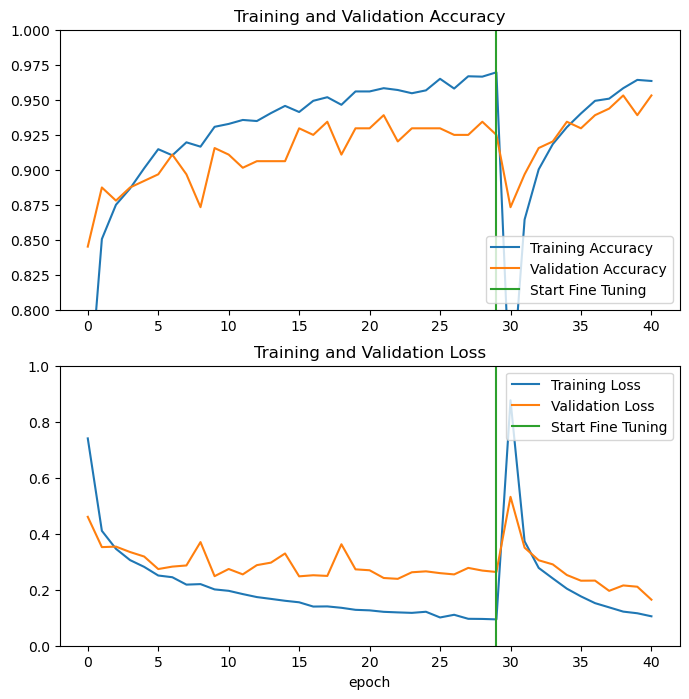

In [94]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([INIT_EPOCH-1,INIT_EPOCH-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([INIT_EPOCH-1,INIT_EPOCH-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation on test dataset

In [95]:
loss, accuracy = model.evaluate(data_sets['test'])

print("Test loss: {:.2f}".format(loss))
print("Test accuracy: {:.2f}".format(accuracy))

7/7 [==============================] - 6s 843ms/step - loss: 0.2704 - accuracy: 0.9364
Test loss: 0.27
Test accuracy: 0.94


## Prediction on test dataset

In [96]:
# Do a prediction on test dataset
prediction_results = model.predict(data_sets['test'])
print('prediction_results:', prediction_results)
print('prediction_results len:', len(prediction_results))

# Find prediction ids
predicted_id = tf.math.argmax(prediction_results, axis=1)
print('predicted_id:', predicted_id)
print('predicted_id len:', len(predicted_id))

# Show dataset class names
class_names = np.array(class_names)
print('class_names:', class_names)

# Converts prediction ids into class names
predicted_label_batch = class_names[predicted_id]
print('predicted_label_batch:', predicted_label_batch)

predictions_df = pd.DataFrame(prediction_results)

7/7 [==============================] - 6s 746ms/step
prediction_results: [[8.62228334e-01 6.82073096e-06 1.37711152e-01 5.37602427e-05]
 [4.03477788e-01 2.35227332e-03 5.92815578e-01 1.35438237e-03]
 [8.98215234e-01 3.02825253e-02 6.03030552e-04 7.08992556e-02]
 [9.99264181e-01 1.64649173e-04 2.46329582e-05 5.46509458e-04]
 [9.36726213e-01 1.00297744e-04 4.51363344e-03 5.86599037e-02]
 [9.98519957e-01 1.46132734e-05 7.36286282e-04 7.29170628e-04]
 [9.94496763e-01 2.86071881e-05 3.21688021e-05 5.44253457e-03]
 [9.99988556e-01 1.49598532e-06 1.31379943e-06 8.63626610e-06]
 [9.57102835e-01 1.99106536e-04 1.77174620e-02 2.49806046e-02]
 [9.99724209e-01 3.40038946e-06 7.51651314e-05 1.97101661e-04]
 [9.97528732e-01 1.31987588e-04 1.43633704e-04 2.19559926e-03]
 [9.98933494e-01 2.50589219e-04 5.11628496e-05 7.64779979e-04]
 [9.99902248e-01 1.36915733e-05 1.19797014e-05 7.20179087e-05]
 [8.60591352e-01 2.32710131e-03 5.64870657e-04 1.36516735e-01]
 [9.95081782e-01 2.14301283e-04 2.46805768e-0

In [97]:
predictions_df

,0,1,2,3
0,0.862228,0.000007,0.137711,0.000054
1,0.403478,0.002352,0.592816,0.001354
2,0.898215,0.030283,0.000603,0.070899
3,0.999264,0.000165,0.000025,0.000547
4,0.936726,0.000100,0.004514,0.058660
...,...,...,...,...
215,0.001296,0.108992,0.000031,0.889681
216,0.000705,0.000571,0.004789,0.993935
217,0.000014,0.000012,0.000014,0.999960
218,0.001972,0.000201,0.000174,0.997653


In [98]:
# Add y_pred into predictions_df

predictions_df['y_pred'] = predicted_id
predictions_df

,0,1,2,3,y_pred
0,0.862228,0.000007,0.137711,0.000054,0
1,0.403478,0.002352,0.592816,0.001354,2
2,0.898215,0.030283,0.000603,0.070899,0
3,0.999264,0.000165,0.000025,0.000547,0
4,0.936726,0.000100,0.004514,0.058660,0
...,...,...,...,...,...
215,0.001296,0.108992,0.000031,0.889681,3
216,0.000705,0.000571,0.004789,0.993935,3
217,0.000014,0.000012,0.000014,0.999960,3
218,0.001972,0.000201,0.000174,0.997653,3


In [99]:
# Add y_true into predictions_df

predictions_df['y_true'] = data_sets['test'].classes
predictions_df

,0,1,2,3,y_pred,y_true
0,0.862228,0.000007,0.137711,0.000054,0,0
1,0.403478,0.002352,0.592816,0.001354,2,0
2,0.898215,0.030283,0.000603,0.070899,0,0
3,0.999264,0.000165,0.000025,0.000547,0,0
4,0.936726,0.000100,0.004514,0.058660,0,0
...,...,...,...,...,...,...
215,0.001296,0.108992,0.000031,0.889681,3,3
216,0.000705,0.000571,0.004789,0.993935,3,3
217,0.000014,0.000012,0.000014,0.999960,3,3
218,0.001972,0.000201,0.000174,0.997653,3,3


In [100]:
# Rename all the column headers

predictions_df.columns = [class_names[0], class_names[1], class_names[2], class_names[3], 'y_pred', 'y_true']
predictions_df

,Cataract,DR,Glaucoma,Normal,y_pred,y_true
0,0.862228,0.000007,0.137711,0.000054,0,0
1,0.403478,0.002352,0.592816,0.001354,2,0
2,0.898215,0.030283,0.000603,0.070899,0,0
3,0.999264,0.000165,0.000025,0.000547,0,0
4,0.936726,0.000100,0.004514,0.058660,0,0
...,...,...,...,...,...,...
215,0.001296,0.108992,0.000031,0.889681,3,3
216,0.000705,0.000571,0.004789,0.993935,3,3
217,0.000014,0.000012,0.000014,0.999960,3,3
218,0.001972,0.000201,0.000174,0.997653,3,3


In [101]:
# Converts y_pred into numpy array

y_pred_in_numpy = np.array(predictions_df['y_pred'])
y_pred_in_numpy

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 3, 2, 2, 2, 2, 2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
      dtype=int64)

In [102]:
# Converts y_true into numpy array

y_true_in_numpy = np.array(predictions_df['y_true'])
y_true_in_numpy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [103]:
# Create the mixed splitted dataset CSV

csv_file_name = 'test_mixed_splitted_dataset.csv'
csv_path = main_dataset_dir
dataset_source = dataset_dir
headers = ['Image', 'Label']

create_csv_file_from_dataset(csv_file_name, csv_path, headers, dataset_source, dataset_type='test')

Generating CSV file is completed.
CSV file successfully created in "D:/2110191048\Dataset\test_mixed_splitted_dataset.csv"


In [104]:
# Load and preview the CSV dataset file

test_mixed_df = pd.read_csv(os.path.join(main_dataset_dir, csv_file_name))
test_mixed_df

,Image,Label
0,mixed - 10 - cataract (1003).jpg,Cataract
1,mixed - 10 - cataract (1038).jpg,Cataract
2,mixed - 10 - cataract (11).jpg,Cataract
3,mixed - 10 - cataract (112).jpg,Cataract
4,mixed - 10 - cataract (119).jpg,Cataract
...,...,...
215,mixed - 10 - normal (881).jpg,Normal
216,mixed - 10 - normal (942).jpg,Normal
217,mixed - 10 - normal (966).jpg,Normal
218,mixed - 10 - normal (980).jpg,Normal


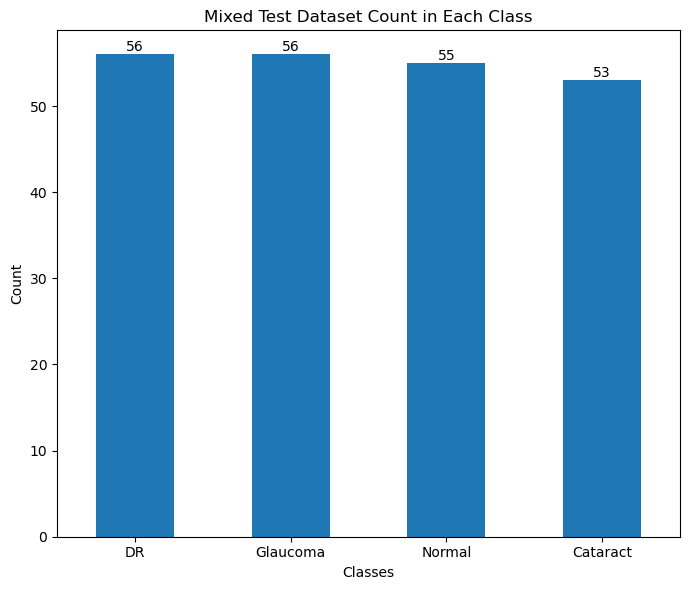

In [105]:
# Plotting the dataset count in each class

plot_title = 'Mixed Test Dataset Count in Each Class'
plot_dataset(test_mixed_df, plot_title)

In [106]:
# Preview predicted results for some images in test dataset

cataract_test_path = f'{dataset_dir}\\test\\Cataract\\'
dr_test_path = f'{dataset_dir}\\test\\DR\\'
glaucoma_test_path = f'{dataset_dir}\\test\\Glaucoma\\'
normal_test_path = f'{dataset_dir}\\test\\Normal\\'

def show_predicted_results(dataset_df):
    sample_test = dataset_df.head(18)
    sample_test.head()
    class_indices = data_sets['test'].class_indices
    plt.figure(figsize=(12, 24))

    for index, row in sample_test.iterrows():
        filename = row['Image']
        category = row['Label']
        y_pred = predictions_df['y_pred'][index]
        classes = list(filter(lambda x: class_indices[x] == y_pred, class_indices))[0]
        img = load_img(cataract_test_path + filename, target_size=IMG_SIZE)
        plt.subplot(6, 3, index+1)      
        plt.imshow(img)
        plt.xlabel(filename + f" ({category})\n is predicted as {classes}")

    plt.suptitle(f'Preview Some Predicted Results on Test Dataset')
    plt.tight_layout()
    plt.show()

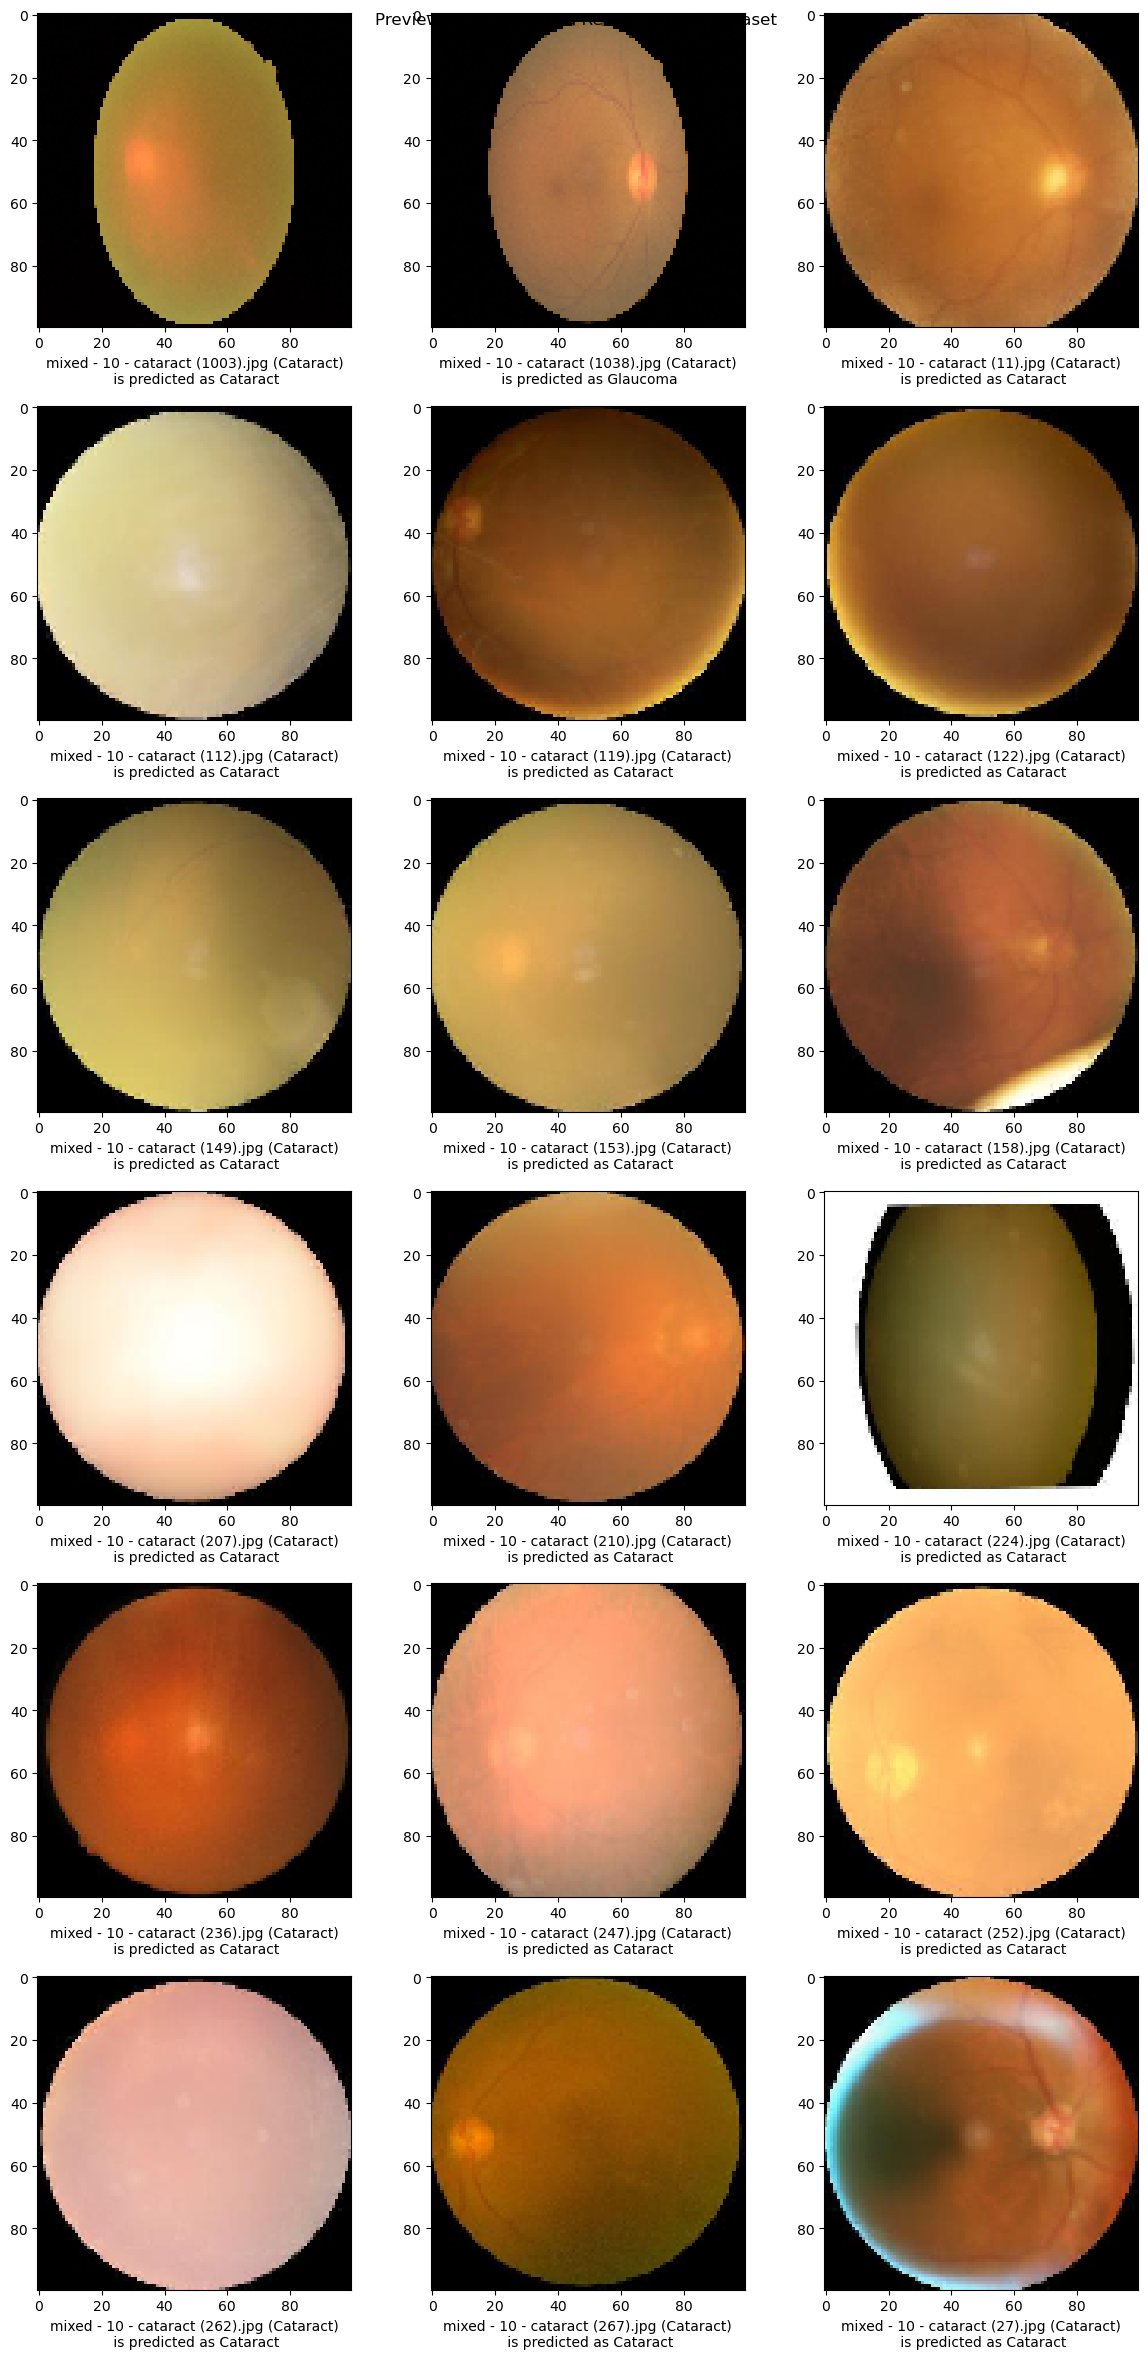

In [107]:
# Preview some predicted results in test dataset

show_predicted_results(test_mixed_df)

## Evaluation metrics

In [108]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay

### Classification reports

In [109]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true_in_numpy, y_pred_in_numpy)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true_in_numpy, y_pred_in_numpy, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true_in_numpy, y_pred_in_numpy, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true_in_numpy, y_pred_in_numpy, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true_in_numpy, y_pred_in_numpy, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true_in_numpy, y_pred_in_numpy, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true_in_numpy, y_pred_in_numpy, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true_in_numpy, y_pred_in_numpy, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true_in_numpy, y_pred_in_numpy, average='weighted')))
print('Weighted F1-score: {:.2f}\n'.format(f1_score(y_true_in_numpy, y_pred_in_numpy, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_true_in_numpy, y_pred_in_numpy, target_names=class_names))


Accuracy: 0.94

Micro Precision: 0.94
Micro Recall: 0.94
Micro F1-score: 0.94

Macro Precision: 0.94
Macro Recall: 0.94
Macro F1-score: 0.94

Weighted Precision: 0.94
Weighted Recall: 0.94
Weighted F1-score: 0.94


Classification Report

              precision    recall  f1-score   support

    Cataract       0.98      0.91      0.94        53
          DR       0.93      0.98      0.96        56
    Glaucoma       0.93      0.91      0.92        56
      Normal       0.91      0.95      0.93        55

    accuracy                           0.94       220
   macro avg       0.94      0.94      0.94       220
weighted avg       0.94      0.94      0.94       220



### Confusion matrix

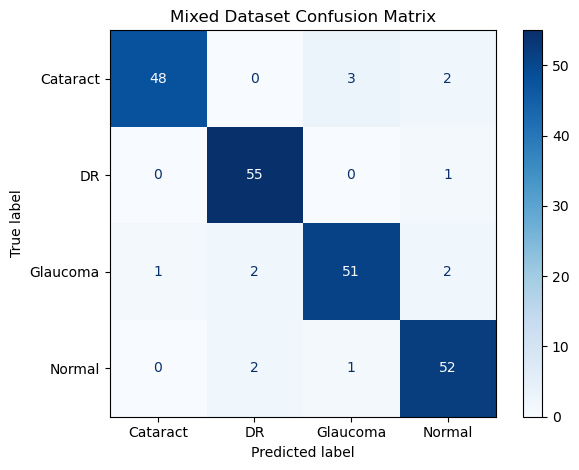

In [110]:
# Plot the confusion matrix

cm = confusion_matrix(y_true_in_numpy, y_pred_in_numpy)

# Create labels for the matrix
labels = list(data_sets['test'].class_indices.keys())

# Plot the confusion matrix
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmap = plt.colormaps['Blues']
cmd.plot(cmap=cmap, colorbar=True)
plt.title('Mixed Dataset Confusion Matrix')
plt.tight_layout()
plt.show()

## Save the model

In [111]:
# model.save('')

## Use trained model for prediction

In [112]:
saved_model = load_model(os.path.join(trained_model_path, 'resnet50v2_mixed_best_model.h5'), compile=True)

In [113]:
new_prediction_result = saved_model.predict(data_sets['test'])
print('Number of new predicted images:', len(new_prediction_result))
print('New prediction result:', new_prediction_result)
print('New prediction result shape:', new_prediction_result.shape)

new_predictions_df = pd.DataFrame(new_prediction_result)

7/7 [==============================] - 6s 748ms/step
Number of new predicted images: 220
New prediction result: [[8.62228334e-01 6.82073096e-06 1.37711152e-01 5.37602427e-05]
 [4.03477788e-01 2.35227332e-03 5.92815578e-01 1.35438237e-03]
 [8.98215234e-01 3.02825253e-02 6.03030552e-04 7.08992556e-02]
 [9.99264181e-01 1.64649173e-04 2.46329582e-05 5.46509458e-04]
 [9.36726213e-01 1.00297744e-04 4.51363344e-03 5.86599037e-02]
 [9.98519957e-01 1.46132734e-05 7.36286282e-04 7.29170628e-04]
 [9.94496763e-01 2.86071881e-05 3.21688021e-05 5.44253457e-03]
 [9.99988556e-01 1.49598532e-06 1.31379943e-06 8.63626610e-06]
 [9.57102835e-01 1.99106536e-04 1.77174620e-02 2.49806046e-02]
 [9.99724209e-01 3.40038946e-06 7.51651314e-05 1.97101661e-04]
 [9.97528732e-01 1.31987588e-04 1.43633704e-04 2.19559926e-03]
 [9.98933494e-01 2.50589219e-04 5.11628496e-05 7.64779979e-04]
 [9.99902248e-01 1.36915733e-05 1.19797014e-05 7.20179087e-05]
 [8.60591352e-01 2.32710131e-03 5.64870657e-04 1.36516735e-01]
 [9.95

In [114]:
new_predicted_id = tf.math.argmax(new_prediction_result, axis=1)
print('new_predicted_id len:', len(new_predicted_id))
print('new_predicted_id shape:', new_predicted_id.shape)
print('new_predicted_id:', new_predicted_id)
# class_names = np.array(class_names)
# predicted_label_batch = class_names[predicted_id]

# # print('Predictions:\n', predictions.numpy())
# print('Predictions:\n', predicted_label_batch)
# print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   # plt.title(class_names[predictions[i]])
#   plt.title(predicted_label_batch[i])
#   plt.axis("off")

new_predicted_id len: 220
new_predicted_id shape: (220,)
new_predicted_id: tf.Tensor(
[0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 2 2 0 0 0 0 0
 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 3 2 2 2 2 2 3 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3], shape=(220,), dtype=int64)


In [115]:
new_y_pred_in_numpy = np.array(new_predicted_id)
new_y_pred_in_numpy

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 3, 2, 2, 2, 2, 2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
      dtype=int64)

In [116]:
new_y_true_in_numpy = np.array(data_sets['test'].classes)
new_y_true_in_numpy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [117]:
new_predictions_df

,0,1,2,3
0,0.862228,0.000007,0.137711,0.000054
1,0.403478,0.002352,0.592816,0.001354
2,0.898215,0.030283,0.000603,0.070899
3,0.999264,0.000165,0.000025,0.000547
4,0.936726,0.000100,0.004514,0.058660
...,...,...,...,...
215,0.001296,0.108992,0.000031,0.889681
216,0.000705,0.000571,0.004789,0.993935
217,0.000014,0.000012,0.000014,0.999960
218,0.001972,0.000201,0.000174,0.997653


In [118]:
# Converts each predicted value into labels

new_predictions_df['y_pred'] = new_y_pred_in_numpy
new_predictions_df

,0,1,2,3,y_pred
0,0.862228,0.000007,0.137711,0.000054,0
1,0.403478,0.002352,0.592816,0.001354,2
2,0.898215,0.030283,0.000603,0.070899,0
3,0.999264,0.000165,0.000025,0.000547,0
4,0.936726,0.000100,0.004514,0.058660,0
...,...,...,...,...,...
215,0.001296,0.108992,0.000031,0.889681,3
216,0.000705,0.000571,0.004789,0.993935,3
217,0.000014,0.000012,0.000014,0.999960,3
218,0.001972,0.000201,0.000174,0.997653,3


In [119]:
# Add y_true into new_predictions_df

# print(data_sets['test'].classes)
new_predictions_df['y_true'] = new_y_true_in_numpy
new_predictions_df

,0,1,2,3,y_pred,y_true
0,0.862228,0.000007,0.137711,0.000054,0,0
1,0.403478,0.002352,0.592816,0.001354,2,0
2,0.898215,0.030283,0.000603,0.070899,0,0
3,0.999264,0.000165,0.000025,0.000547,0,0
4,0.936726,0.000100,0.004514,0.058660,0,0
...,...,...,...,...,...,...
215,0.001296,0.108992,0.000031,0.889681,3,3
216,0.000705,0.000571,0.004789,0.993935,3,3
217,0.000014,0.000012,0.000014,0.999960,3,3
218,0.001972,0.000201,0.000174,0.997653,3,3


In [120]:
new_predictions_df.columns = [class_names[0], class_names[1], class_names[2], class_names[3], 'y_pred', 'y_true']
new_predictions_df

,Cataract,DR,Glaucoma,Normal,y_pred,y_true
0,0.862228,0.000007,0.137711,0.000054,0,0
1,0.403478,0.002352,0.592816,0.001354,2,0
2,0.898215,0.030283,0.000603,0.070899,0,0
3,0.999264,0.000165,0.000025,0.000547,0,0
4,0.936726,0.000100,0.004514,0.058660,0,0
...,...,...,...,...,...,...
215,0.001296,0.108992,0.000031,0.889681,3,3
216,0.000705,0.000571,0.004789,0.993935,3,3
217,0.000014,0.000012,0.000014,0.999960,3,3
218,0.001972,0.000201,0.000174,0.997653,3,3


In [121]:
# Creating CSV file path and its headers

csv_file_path = 'D:\\2110191048\\Dataset\\new_test_dataset_mixed.csv'
headers = ['Image', 'Label']

In [122]:
# Write the CSV file

with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(headers)

In [123]:
# Fill the CSV file with the image path and their label

supported_extensions = ['.png', '.jpg', '.jpeg']

for root, dirs, files in os.walk('D:\\2110191048\\Dataset\\Dataset (Splitted)\\test'):
    for file in files:
        if any(file.lower().endswith(ext) for ext in supported_extensions):
            image_path = os.path.join(root, file)
            label = os.path.basename(root)
            with open(csv_file_path, 'a', newline='') as csv_file:
                writer = csv.writer(csv_file)
                writer.writerow([file, label])

In [124]:
# Load and preview the CSV dataset file

new_test_mixed_df = pd.read_csv('D:\\2110191048\\Dataset\\new_test_dataset_mixed.csv')
new_test_mixed_df

,Image,Label
0,mixed - 10 - cataract (1003).jpg,Cataract
1,mixed - 10 - cataract (1038).jpg,Cataract
2,mixed - 10 - cataract (11).jpg,Cataract
3,mixed - 10 - cataract (112).jpg,Cataract
4,mixed - 10 - cataract (119).jpg,Cataract
...,...,...
215,mixed - 10 - normal (881).jpg,Normal
216,mixed - 10 - normal (942).jpg,Normal
217,mixed - 10 - normal (966).jpg,Normal
218,mixed - 10 - normal (980).jpg,Normal


Label
DR          56
Glaucoma    56
Normal      55
Cataract    53
Name: count, dtype: int64

Total predicted images: 220


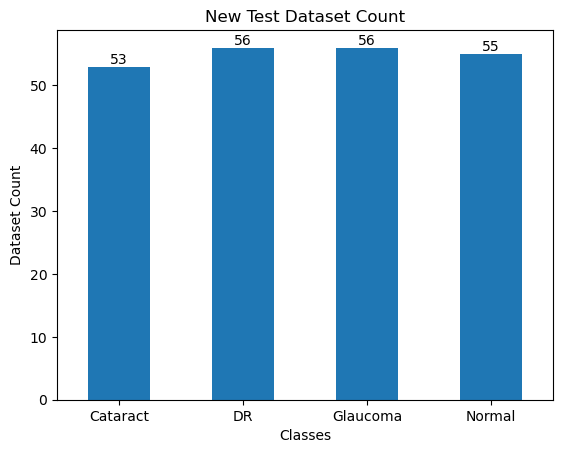

In [125]:
new_test_mixed_df['Label'].value_counts()
print(new_test_mixed_df['Label'].value_counts())

# View the above in a bar graph
new_test_df_chart = new_test_mixed_df.groupby('Label')['Image'].nunique().plot(
    kind='bar',
    title='New Test Dataset Count',
    xlabel='Classes',
    ylabel='Dataset Count',
    rot=0
)

new_test_df_chart.bar_label(new_test_df_chart.containers[0])

# Lets print the total predicted images 
print("\nTotal predicted images:", new_test_mixed_df.shape[0])

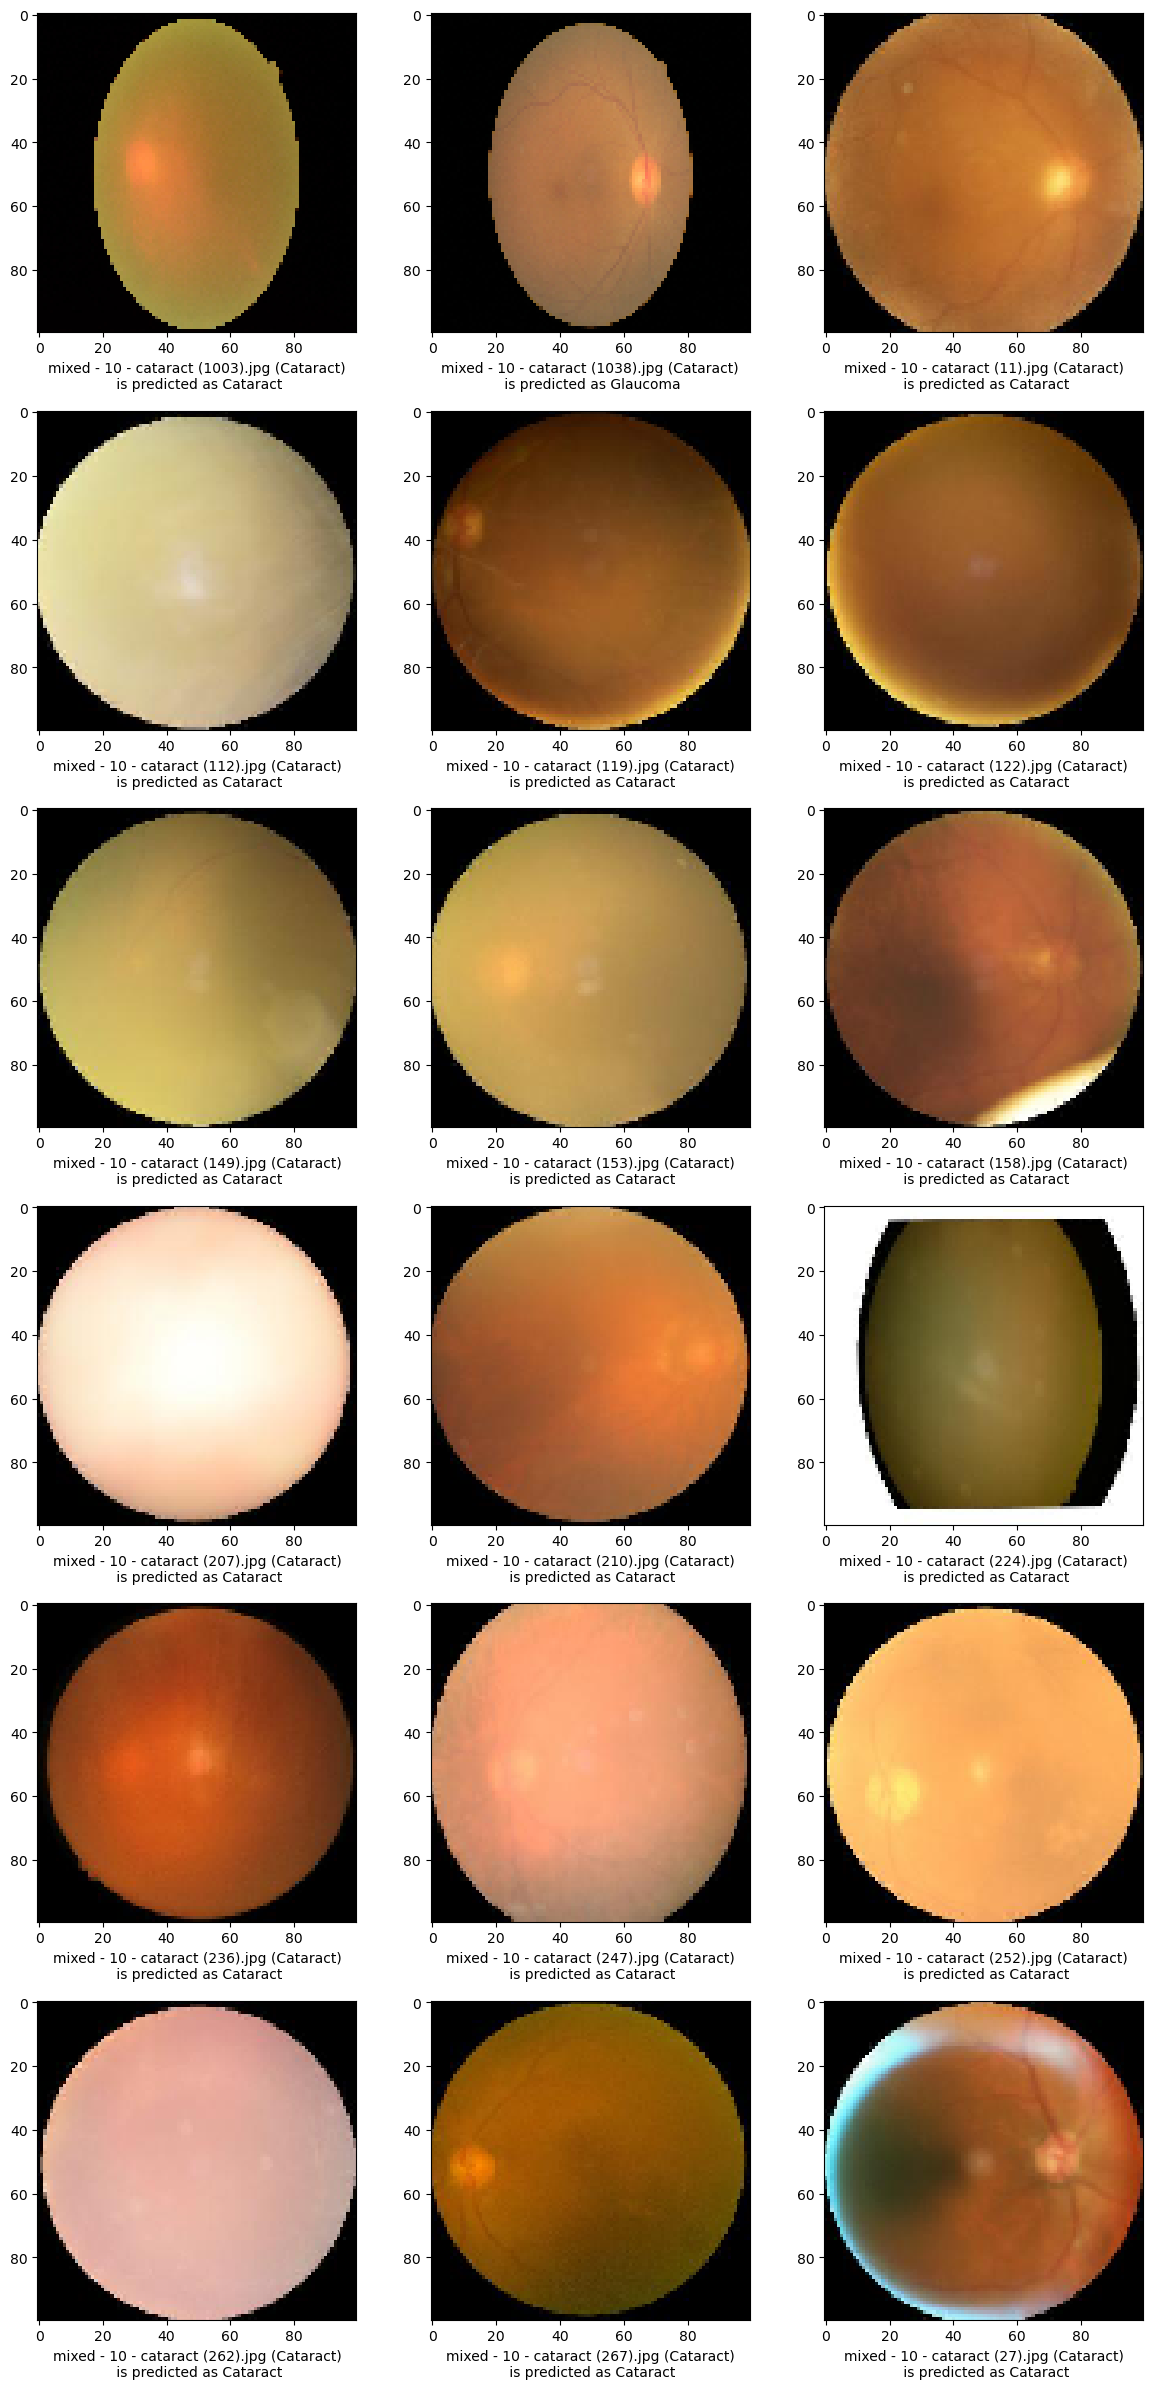

In [126]:
from tensorflow.keras.preprocessing.image import load_img

sample_test = new_test_mixed_df.head(18)
sample_test.head()
class_indices = data_sets['test'].class_indices
plt.figure(figsize=(12, 24))

for index, row in sample_test.iterrows():
    filename = row['Image']
    category = row['Label']
    y_pred = predictions_df['y_pred'][index]
    classes = list(filter(lambda x: class_indices[x] == y_pred, class_indices))[0]
    img = load_img('D:\\2110191048\\Dataset\\Dataset (Splitted)\\test\\Cataract\\' + filename, target_size=IMG_SIZE)
    plt.subplot(6, 3, index+1)      
    plt.imshow(img)
    plt.xlabel(filename + f" ({category})\n is predicted as {classes}")

plt.tight_layout()
plt.show()

In [127]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(new_y_true_in_numpy, new_y_pred_in_numpy)))

print('Micro Precision: {:.2f}'.format(precision_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='weighted')))
print('Weighted F1-score: {:.2f}\n'.format(f1_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='weighted')))

print('\nClassification Report\n')
print(classification_report(new_y_true_in_numpy, new_y_pred_in_numpy, target_names=class_names))


Accuracy: 0.94

Micro Precision: 0.94
Micro Recall: 0.94
Micro F1-score: 0.94

Macro Precision: 0.94
Macro Recall: 0.94
Macro F1-score: 0.94

Weighted Precision: 0.94
Weighted Recall: 0.94
Weighted F1-score: 0.94


Classification Report

              precision    recall  f1-score   support

    Cataract       0.98      0.91      0.94        53
          DR       0.93      0.98      0.96        56
    Glaucoma       0.93      0.91      0.92        56
      Normal       0.91      0.95      0.93        55

    accuracy                           0.94       220
   macro avg       0.94      0.94      0.94       220
weighted avg       0.94      0.94      0.94       220



In [128]:
# Let's try, if the model can predict just one image or not

from tensorflow.keras.preprocessing import image

def predict_one_image(img_path, model=model):
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = tf.expand_dims(img_array, axis=0)
    
    print('img_array shape:', img_array.shape) 
    print('img_array type:', type(img_array))
    
    prediction_result = model.predict(img_array)
    
    print('Prediction_result:', prediction_result)    
    print('Prediction_result shape:', prediction_result.shape)    
    print('Prediction_result type:', type(prediction_result))   

    print('prediction_result[0]:', prediction_result[0])
    
    score = tf.nn.softmax(prediction_result[0])
    print('score:', score) 
    
    predicted_class = tf.argmax(prediction_result[0])
    print('Prediction_class:', class_names[predicted_class.numpy()])

glaucoma_normal_test_image = test_image_source = 'D:\\2110191048\\eye-disease-classification-app\\deep-learning-model\\mixed_test_images\\Cataract.jpg'
predict_one_image(glaucoma_normal_test_image, saved_model)

img_array shape: (1, 100, 100, 3)
img_array type: <class 'tensorflow.python.framework.ops.EagerTensor'>


1/1 [==============================] - 2s 2s/step
Prediction_result: [[8.982158e-01 3.028196e-02 6.030165e-04 7.089923e-02]]
Prediction_result shape: (1, 4)
Prediction_result type: <class 'numpy.ndarray'>
prediction_result[0]: [8.982158e-01 3.028196e-02 6.030165e-04 7.089923e-02]
score: tf.Tensor([0.4415829  0.1853845  0.1799633  0.19306931], shape=(4,), dtype=float32)
Prediction_class: Cataract
